In [20]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist
to_categorical = tf.keras.utils.to_categorical

In [ ]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalize pixel values to the range [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Reshape data to add a channel dimension (needed for CNNs)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")

4422102/4422102 [==============================] - 1s 0us/step
Training data shape: (60000, 28, 28, 1)
Training labels shape: (60000, 10)
Testing data shape: (10000, 28, 28, 1)
Testing labels shape: (10000, 10)


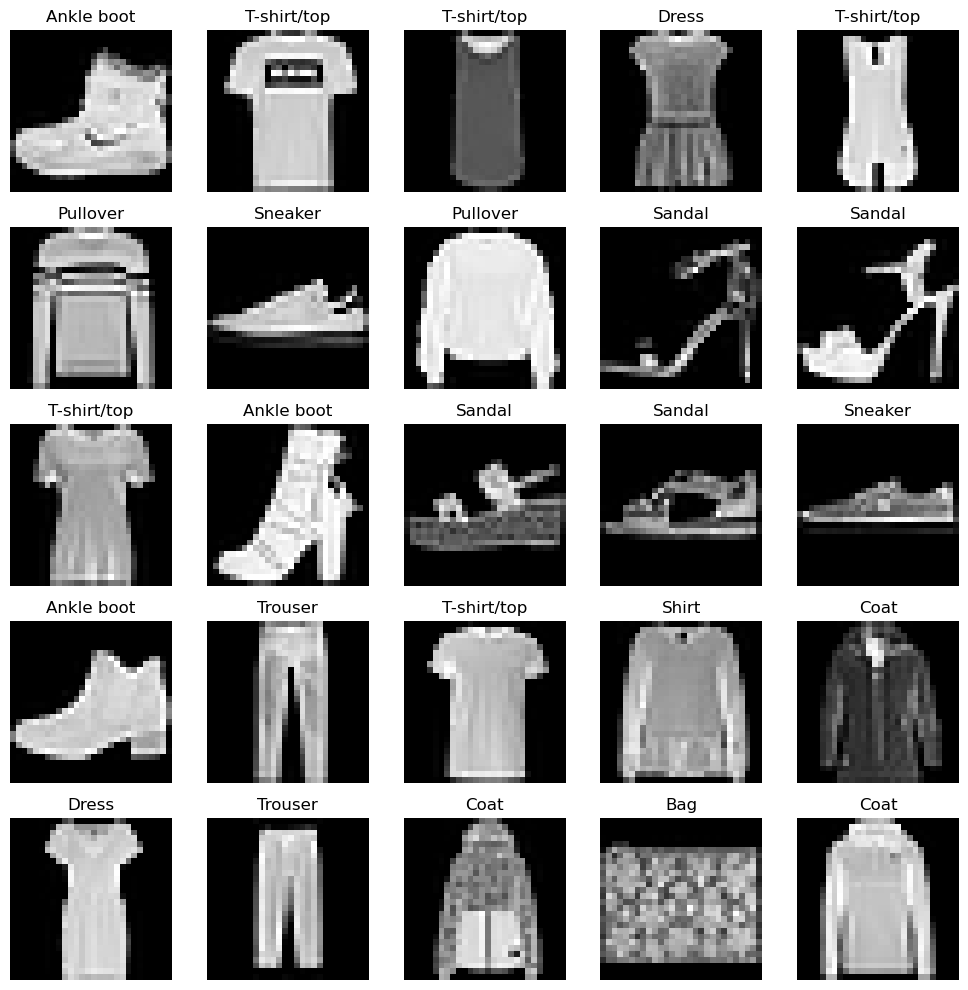

In [6]:
# Define class names for the dataset
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress",
    "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Visualize a few samples from the training dataset
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_train[i].reshape(28, 28), cmap="gray")
    plt.title(class_names[np.argmax(y_train[i])])
    plt.axis("off")
    
plt.tight_layout()
plt.show()

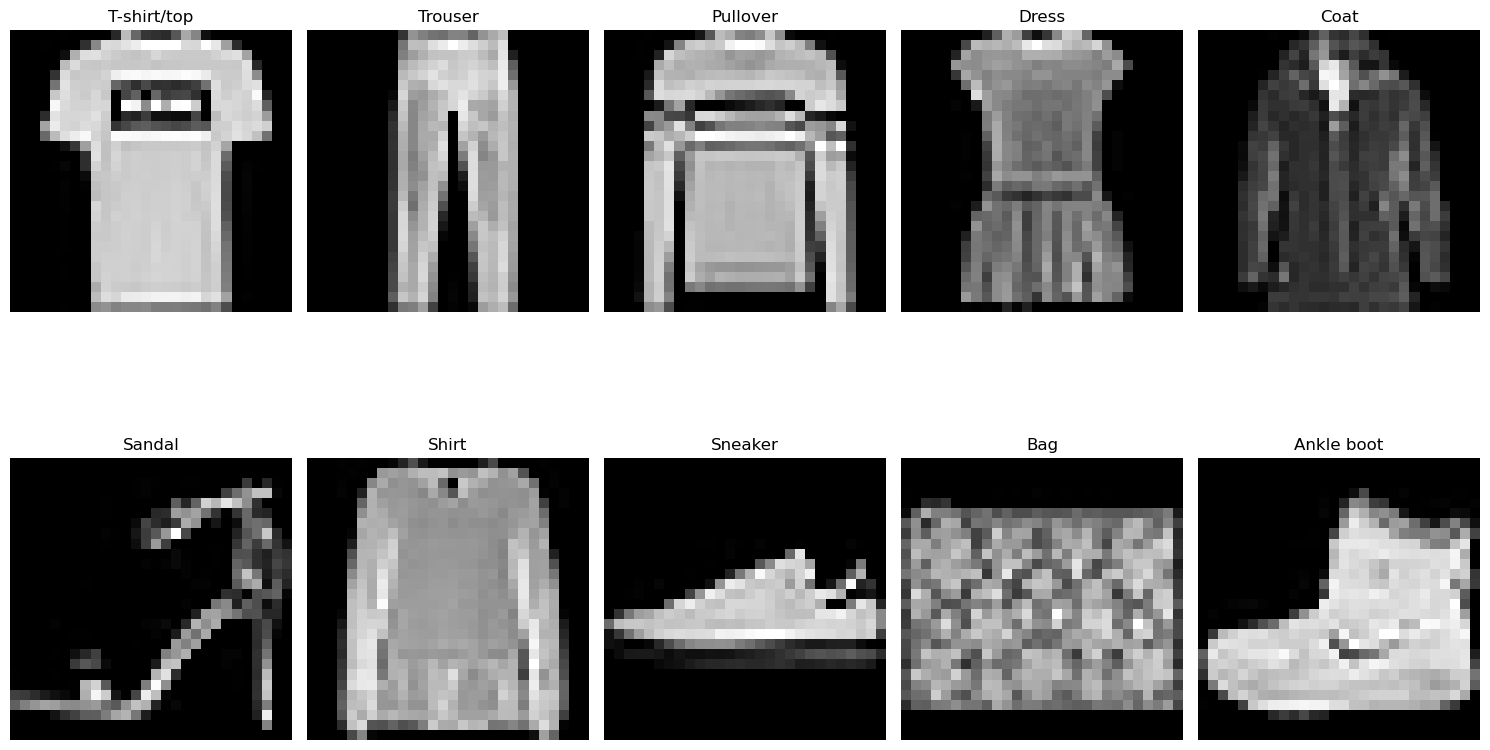

In [7]:
# Visualize one sample from each class
plt.figure(figsize=(15, 10))
for i in range(10):
    sample_idx = np.where(np.argmax(y_train, axis=1) == i)[0][0]
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[sample_idx].reshape(28, 28), cmap="gray")
    plt.title(class_names[i], fontsize=12)
    plt.axis("off")
    
plt.tight_layout()
plt.show()

In [9]:
missing_train = np.isnan(X_train).sum()
missing_test = np.isnan(X_test).sum()

print(f"Missing values in training data: {missing_train}")
print(f"Missing values in testing data: {missing_test}")

Missing values in training data: 0
Missing values in testing data: 0


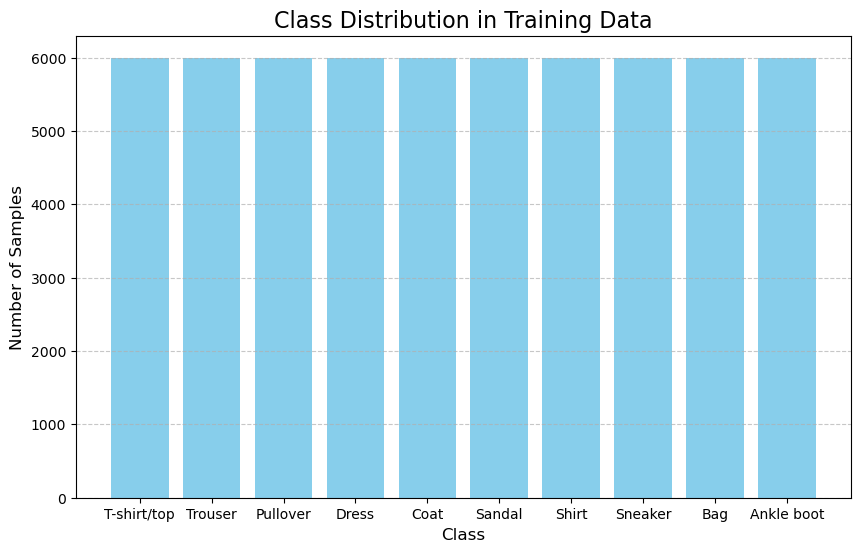

In [11]:
class_counts = np.sum(y_train, axis=0)

plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts, color="skyblue")
plt.title("Class Distribution in Training Data", fontsize=16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

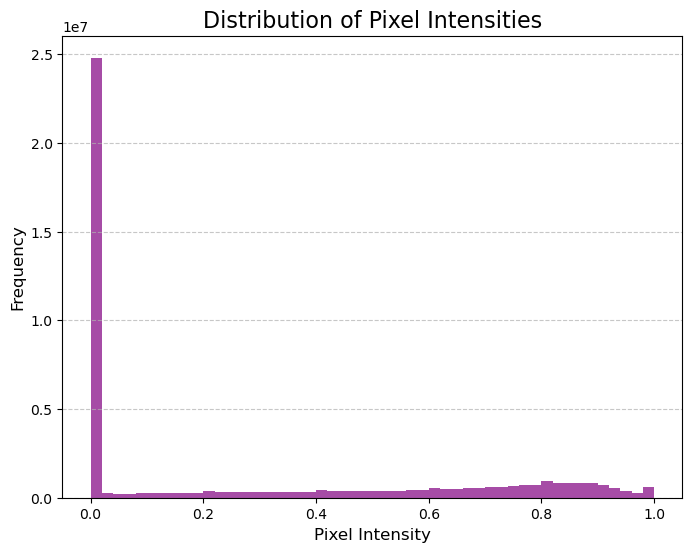

In [12]:
pixel_values = X_train.flatten()

plt.figure(figsize=(8, 6))
plt.hist(pixel_values, bins=50, color="purple", alpha=0.7)
plt.title("Distribution of Pixel Intensities", fontsize=16)
plt.xlabel("Pixel Intensity", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [13]:
pixel_stats = {
    "Mean": np.mean(pixel_values),
    "Median": np.median(pixel_values),
    "Standard Deviation": np.std(pixel_values),
}

# Display the results
for stat, value in pixel_stats.items():
    print(f"{stat}: {value:.4f}")

Mean: 0.2860
Median: 0.0000
Standard Deviation: 0.3530


In [15]:
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [17]:
# Baseline CNN model
def create_baseline_model():
    model = Sequential([
        # Convolutional layer with 32 filters and ReLU activation
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),

        # Convolutional layer with 64 filters
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        # Flatten the output and add dense layers
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')  # Output layer for 10 classes
    ])

    # Compile the model with Adam optimizer and sparse categorical crossentropy loss
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Instantiate the model
baseline_model = create_baseline_model()
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [18]:
batch_size = 64
epochs = 10

# Train the model
history = baseline_model.fit(
    X_train_split, 
    y_train_split,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)

Epoch 1/10
750/750 [==============================] - 34s 44ms/step - loss: 0.6460 - accuracy: 0.7664 - val_loss: 0.3901 - val_accuracy: 0.8587
Epoch 2/10
750/750 [==============================] - 34s 45ms/step - loss: 0.4245 - accuracy: 0.8477 - val_loss: 0.3323 - val_accuracy: 0.8786
Epoch 3/10
750/750 [==============================] - 33s 44ms/step - loss: 0.3662 - accuracy: 0.8682 - val_loss: 0.3106 - val_accuracy: 0.8846
Epoch 4/10
750/750 [==============================] - 38s 50ms/step - loss: 0.3343 - accuracy: 0.8798 - val_loss: 0.2913 - val_accuracy: 0.8913
Epoch 5/10
750/750 [==============================] - 30s 40ms/step - loss: 0.3097 - accuracy: 0.8885 - val_loss: 0.2755 - val_accuracy: 0.8989
Epoch 6/10
750/750 [==============================] - 30s 40ms/step - loss: 0.2924 - accuracy: 0.8944 - val_loss: 0.2595 - val_accuracy: 0.9021
Epoch 7/10
750/750 [==============================] - 32s 42ms/step - loss: 0.2715 - accuracy: 0.9014 - val_loss: 0.2501 - val_accuracy:

In [21]:
test_loss, test_accuracy = baseline_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.2633
Test Accuracy: 0.9020


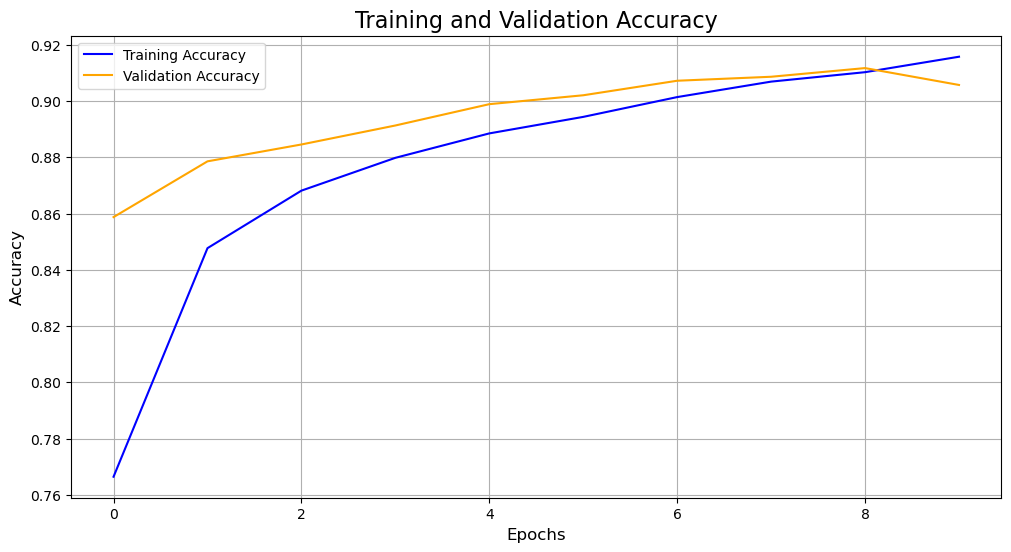

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

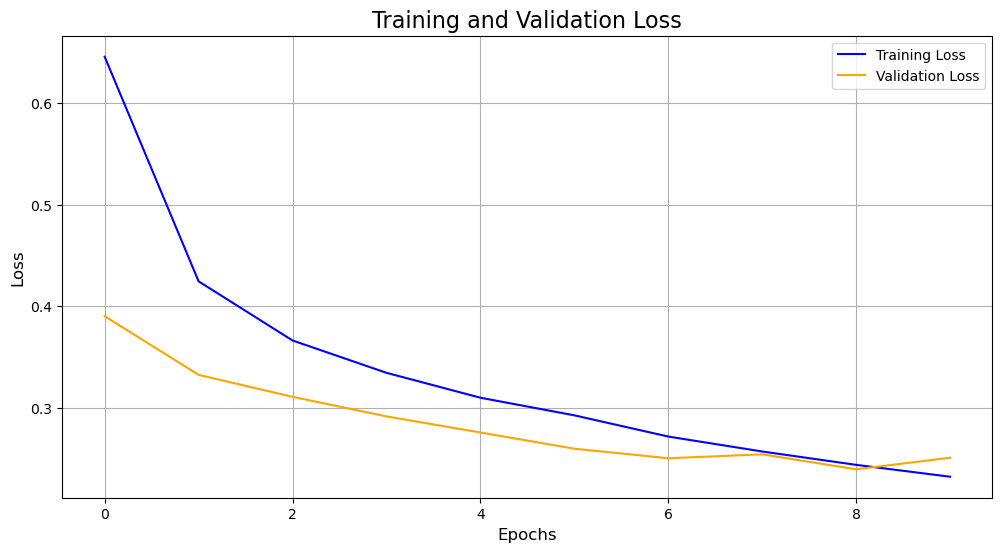

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [24]:
y_pred = baseline_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

313/313 [==============================] - 3s 8ms/step


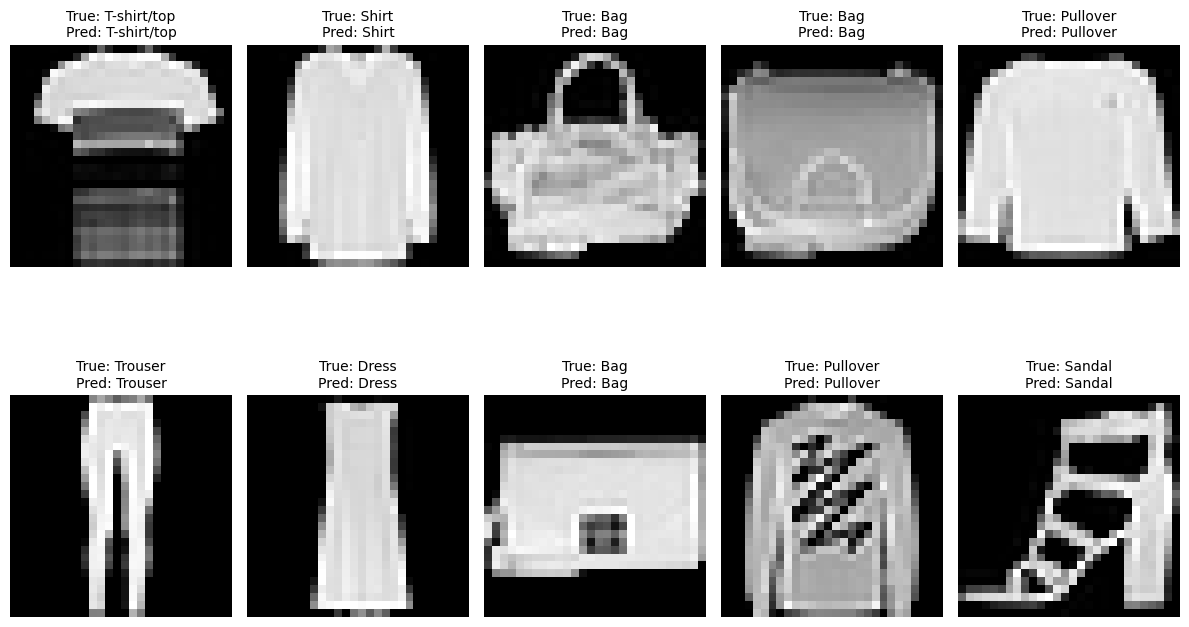

In [25]:
plt.figure(figsize=(12, 8))
for i in range(10):
    idx = np.random.randint(0, len(X_test))
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx].reshape(28, 28), cmap="gray")
    true_label = class_names[np.argmax(y_test[idx])]
    predicted_label = class_names[y_pred_classes[idx]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10)
    plt.axis("off")
plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

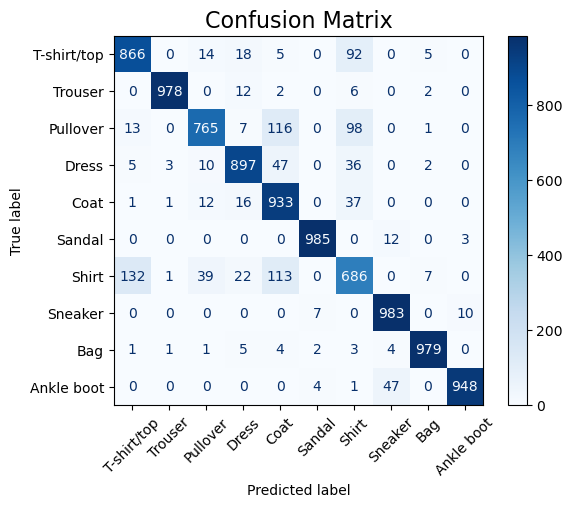

In [26]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix', fontsize=16)
plt.show()